<a href="https://colab.research.google.com/github/akshatagrawal1998/Deep-Learning/blob/main/Transfer%20Learning%20and%20Data%20Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning -
If the classes we are predicting for is not already present in Pretrained model. eg if we are trying to predict cat and dogs but the pretrained model we are using is not trained on cats and dogs class.
then we use transfer learning, basically using some layers of pretrained model and creating some of our own layers.

In transfer learning we use some layers of already trained model which are already trained to detect features and then add few layer as per our requirement on which we do traning of oy=ur data.
Then freeze the convolution layers from the pretrained model so that  their weights do not update and train our added layers on our data.
so thet our new model takes less time to get trained and also uses the benefits of pretrained models.

Transfer learning can be done in 2 ways:
1. Feature Extraction
2. Fine Tuning

- Below is the use of Feature extraction.
- Fine Tuning Use case is in another notebook. 
Link - 

**We are trying to use VGG net as our pretrained model in this example below**

In this usecase, we trained then model, saw that there is overfitting, so applied Data Augmentation technique to reduce it.

# Feature extraction Transfer Learning

In Feature extraction, we only train Dense layers (for classification purpose) and the convolution layers (which are used to detect features) remains same. It is basically used when we want to classify similar labels on which the pretrained model is built (basic features of 1000 classes of ImageNet Dataset remains same) like in classification of human vs monkey - primary features like (eyes, ear, nose, mouth, etc) are very similar. So in such cases we need not to build a whole new CNN. Pretrained model can be used as the primary features are similar. So Feature extraction Transfer Learning is used in such cases.

# Fine Tuning Transfer Learning

Here we not only train Dense layers but also few convolutional layers also so that our model can classify some labels which are very much different from the ones on which the used pretrained model was trained.

# Data Reference link 
- https://www.kaggle.com/datasets/salader/dogs-vs-cats

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats
# downloaded data from kaggle but it is in zip file. We need to unzip it.

100% 1.06G/1.06G [00:57<00:00, 19.2MB/s]
100% 1.06G/1.06G [00:57<00:00, 19.8MB/s]


In [ ]:
# unzipping the file
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
# create an object of VGG16 class, which only includes convolutional layers.

conv_base = VGG16(weights='imagenet', # we need the same weights as when the model was trained on ImageNet dataset
                  include_top=False, # telling not to include top layers i.e Dense layer and output layer, only include conv base
                  input_shape=(150,150,3)
                  )

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
conv_base.summary()

# we see that there are 5 blocks 
# block 1 has 2 conv layer and 1 pooling layer and same with block 2 and 3
# block 4 has 3 conv layer and 1 pooling layer and similarly block 5
# we can very well see that dense layers are not added as part of this conv_base object as we did include_top = False


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# now let's build our sequential model from scratch

model = Sequential()
model.add(conv_base) # adding above conv base to this model
model.add(Flatten()) # flatten layer
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

# we see that after flatten layer 8192 inputs goes to 256 neurons. so trainable parameters = 8192*256 + 256(bias of each newuron) = 2097508


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# then we freeze the conv_base to avoid it's weight updation.

conv_base.trainable = False

In [ ]:
model.summary()

# we see as soon as we set conv_base as non-trainable, total trainable parameters are only 2097665 which was 16812353 initially.
# this happens because weights of conv_base is non trainable now, it only updates weights of dense layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred',  
    label_mode = 'int', # 0 for cat and 1 for dog
    batch_size = 32, # batch wise training
    image_size = (150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [ ]:
# Normalize the pixel values for faster training and better results

def process(image, label):
    image = tensorflow.cast(image/255., tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs=5, validation_data = validation_ds)

Epoch 1/5
625/625 [==============================] - 74s 99ms/step - loss: 0.2730 - accuracy: 0.8852 - val_loss: 0.2110 - val_accuracy: 0.9080
Epoch 2/5
625/625 [==============================] - 64s 102ms/step - loss: 0.1939 - accuracy: 0.9186 - val_loss: 0.2092 - val_accuracy: 0.9106
Epoch 3/5
625/625 [==============================] - 64s 103ms/step - loss: 0.1543 - accuracy: 0.9358 - val_loss: 0.2380 - val_accuracy: 0.9018
Epoch 4/5
625/625 [==============================] - 55s 87ms/step - loss: 0.1297 - accuracy: 0.9471 - val_loss: 0.2102 - val_accuracy: 0.9146
Epoch 5/5
625/625 [==============================] - 64s 102ms/step - loss: 0.1050 - accuracy: 0.9600 - val_loss: 0.3467 - val_accuracy: 0.8848


# Note
We know that previously when we created our own CNN model for cat vs dog classification, we were only getting accuracy of 81% even after using BatchNormalization and Pooling layers.

But here using Transfer learning, we are getting an accuracy of 90.66% with only 5 epochs.

So definitely there is a benefit of using Transfer learning

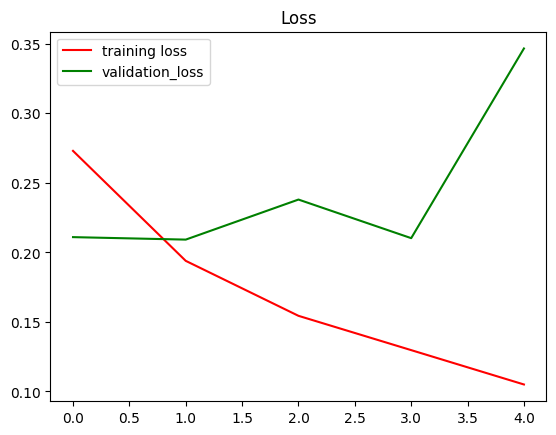

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color = 'red', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'green', label = 'validation_loss')
plt.title("Loss")
plt.legend()
plt.show()

We see in the above graph that training loss is reducing after every epoch but validation loss is increased after a certain epoch. and the huge gap showns overfitting.

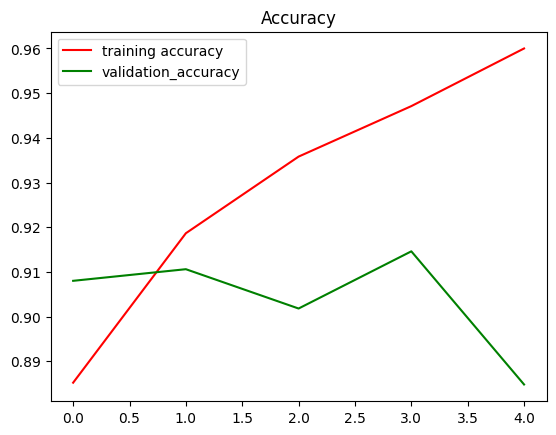

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color = 'red', label = 'training accuracy')
plt.plot(history.history['val_accuracy'], color = 'green', label = 'validation_accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()

We see in the above graph that training accuracy is increasing after every epoch but validation accuracy is stucked around 90% and the huge gap showns overfitting.

# Reduce overfitting:
There are various methods to reduce overfitting
1. batch normalization
2. Dropout layer
3. Regularization
4. adding more data - data augmentation

Here we are using Data Augmentation, there are just few changes from above code.

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array,array_to_img

In [ ]:
# train_ds = keras.utils.image_dataset_from_directory(
#     directory = '/content/train',
#     labels = 'inferred',  
#     label_mode = 'int', # 0 for cat and 1 for dog
#     batch_size = 32, # batch wise training
#     image_size = (150,150)
# )

# validation_ds = keras.utils.image_dataset_from_directory(
#     directory = '/content/test',
#     labels = 'inferred',
#     label_mode = 'int',
#     batch_size = 32,
#     image_size = (150,150)
# )


# Instead of above code we use:

batch_size = 32
# transformations on training data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


# transformations on test data
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary') 

validation_generator = test_datagen.flow_from_directory(
        '/content/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# now let's build a model using conv_base from above

model_1 = Sequential()
model_1.add(conv_base) # adding above conv base to this model
model_1.add(Flatten()) # flatten layer
model_1.add(Dense(256, activation = 'relu'))
model_1.add(Dense(1, activation = 'sigmoid'))

model_1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model_1.fit_generator(
        train_generator,
        epochs=5,
        validation_data=validation_generator)

<ipython-input-24-0f72f6ac8530>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_1.fit_generator(


Epoch 1/5
625/625 [==============================] - 176s 280ms/step - loss: 0.3141 - accuracy: 0.8666 - val_loss: 0.2448 - val_accuracy: 0.8970
Epoch 2/5
625/625 [==============================] - 174s 278ms/step - loss: 0.2393 - accuracy: 0.8992 - val_loss: 0.2075 - val_accuracy: 0.9098
Epoch 3/5
625/625 [==============================] - 178s 285ms/step - loss: 0.2246 - accuracy: 0.9071 - val_loss: 0.2215 - val_accuracy: 0.9028
Epoch 4/5
625/625 [==============================] - 179s 286ms/step - loss: 0.2140 - accuracy: 0.9086 - val_loss: 0.1960 - val_accuracy: 0.9184
Epoch 5/5
625/625 [==============================] - 176s 282ms/step - loss: 0.2067 - accuracy: 0.9111 - val_loss: 0.1951 - val_accuracy: 0.9194


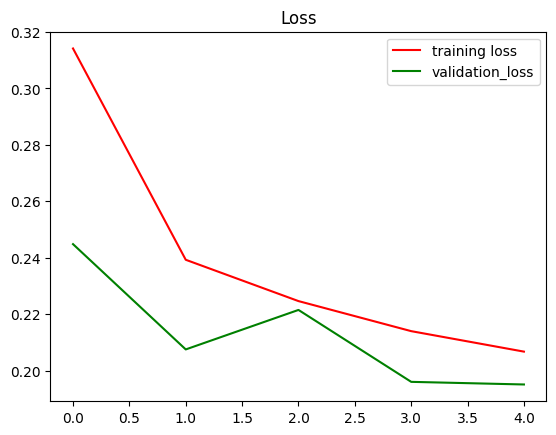

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color = 'red', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'green', label = 'validation_loss')
plt.title("Loss")
plt.legend()
plt.show()

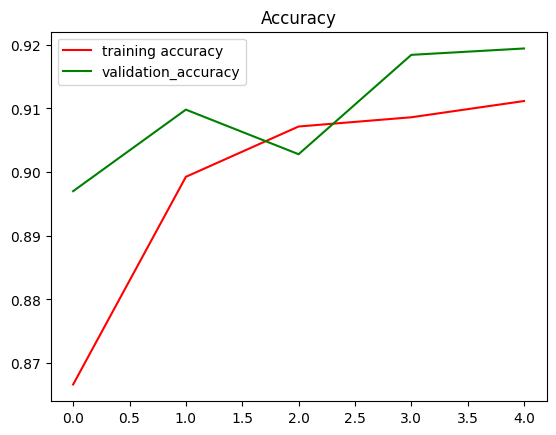

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color = 'red', label = 'training accuracy')
plt.plot(history.history['val_accuracy'], color = 'green', label = 'validation_accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()

# Final Conclusion

We see that gaps between the graph lines are reduced and also validation accuracy is improved due to Data Augmentation.
May be for running the model for more number of epochs, accuracy increases.